In [ ]:
# Brain MRI Multiclass Tumor Classification using Vision Transformer (ViT)

**Classes:** glioma, meningioma, pituitary, no tumor  
**Architecture:** Pre-trained Vision Transformer (ViT) fine-tuned on MRI slices


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# ==== PATHS (UPDATED) ====
BASE_DIR  = r"C:\Users\anant\Downloads\brain mri22"  # full folder that contains Training and Testing
TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Testing")

print("Train dir:", TRAIN_DIR)
print("Test dir :", TEST_DIR)
print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes :", os.listdir(TEST_DIR))

# ==== HYPERPARAMETERS ====
IMG_SIZE    = 224
BATCH_SIZE  = 16
NUM_EPOCHS  = 10
VAL_SPLIT   = 0.15
LR          = 1e-4
NUM_WORKERS = 2


Train dir: C:\Users\anant\Downloads\brain mri22\Training
Test dir : C:\Users\anant\Downloads\brain mri22\Testing
Train classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test classes : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# No augmentation for val/test
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ImageFolder expects:
# TRAIN_DIR/glioma, meningioma, notumor, pituitary
full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_dataset       = datasets.ImageFolder(root=TEST_DIR,   transform=test_transform)

class_names = full_train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total training images:", len(full_train_dataset))
print("Total test images:", len(test_dataset))
print("num_classes:", num_classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total training images: 5712
Total test images: 1311
num_classes: 4


In [4]:
# Split training into train + validation
val_size   = int(VAL_SPLIT * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Make sure val uses test_transform (no augmentation)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

len(train_loader), len(val_loader), len(test_loader)


Train size: 4856, Val size: 856


(304, 54, 82)

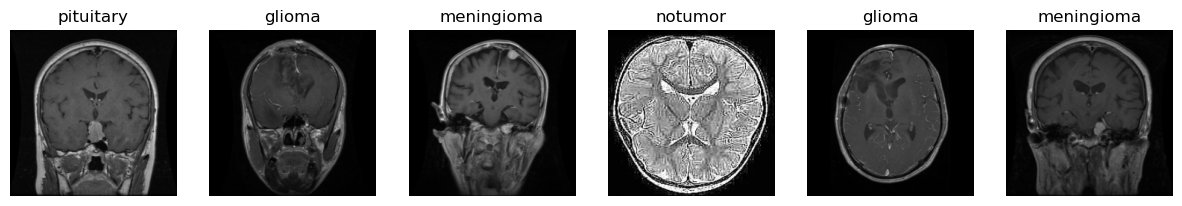

In [5]:
def show_batch(images, labels, class_names):
    images = images[:6]
    labels = labels[:6]

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    imgs = images * std + mean  # unnormalize
    imgs = torch.clamp(imgs, 0, 1)

    fig, axes = plt.subplots(1, len(images), figsize=(15,3))
    for i, ax in enumerate(axes):
        img_np = imgs[i].permute(1,2,0).numpy()
        ax.imshow(img_np)
        ax.set_title(class_names[labels[i].item()])
        ax.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, class_names)


In [ ]:
## Model: Vision Transformer (ViT)

We use a **pre-trained Vision Transformer** model:

- Pre-trained on **ImageNet-1K** (large natural image dataset).
- We **fine-tune** it on our brain MRI dataset.
- Reason for using pre-trained ViT (important for viva):
  - Medical datasets are small and expensive to label.
  - Pre-training on large data helps the model learn generic low-level and mid-level features.
  - We only need to adapt the last layers, which reduces training time and overfitting risk.


In [6]:
model_name = "vit_base_patch16_224"

model = timm.create_model(model_name, pretrained=True)
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)  # 4 classes

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Model: {model_name}, parameters: {total_params:.2f}M")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

C:\Users\anant\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anant\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model: vit_base_patch16_224, parameters: 85.80M


In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)


C:\Users\anant\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.inference_mode():
        for images, labels in tqdm(loader, desc="Val", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)


In [10]:
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_brain_mri.pth")
        print("✅ Saved new best model (val_acc = {:.4f})".format(best_val_acc))

print("Best validation accuracy:", best_val_acc)



Epoch 1/10


Train:   0%|          | 0/304 [00:09<?, ?it/s]

Val:   0%|          | 0/54 [00:10<?, ?it/s]

Train Loss: 0.4012 | Train Acc: 0.8491
Val   Loss: 0.1523 | Val   Acc: 0.9428
✅ Saved new best model (val_acc = 0.9428)

Epoch 2/10


Train:   0%|          | 0/304 [00:09<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.1175 | Train Acc: 0.9619
Val   Loss: 0.1036 | Val   Acc: 0.9661
✅ Saved new best model (val_acc = 0.9661)

Epoch 3/10


Train:   0%|          | 0/304 [00:08<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0731 | Train Acc: 0.9778
Val   Loss: 0.1509 | Val   Acc: 0.9533

Epoch 4/10


Train:   0%|          | 0/304 [00:08<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0958 | Train Acc: 0.9675
Val   Loss: 0.1019 | Val   Acc: 0.9603

Epoch 5/10


Train:   0%|          | 0/304 [00:08<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0779 | Train Acc: 0.9749
Val   Loss: 0.1442 | Val   Acc: 0.9463

Epoch 6/10


Train:   0%|          | 0/304 [00:09<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0818 | Train Acc: 0.9741
Val   Loss: 0.1510 | Val   Acc: 0.9463

Epoch 7/10


Train:   0%|          | 0/304 [00:08<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0502 | Train Acc: 0.9839
Val   Loss: 0.1105 | Val   Acc: 0.9708
✅ Saved new best model (val_acc = 0.9708)

Epoch 8/10


Train:   0%|          | 0/304 [00:08<?, ?it/s]

Val:   0%|          | 0/54 [00:09<?, ?it/s]

Train Loss: 0.0083 | Train Acc: 0.9969
Val   Loss: 0.1294 | Val   Acc: 0.9696

Epoch 9/10


Train:   0%|          | 0/304 [00:09<?, ?it/s]

Val:   0%|          | 0/54 [00:09<?, ?it/s]

Train Loss: 0.0035 | Train Acc: 0.9990
Val   Loss: 0.1051 | Val   Acc: 0.9720
✅ Saved new best model (val_acc = 0.9720)

Epoch 10/10


Train:   0%|          | 0/304 [00:09<?, ?it/s]

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Train Loss: 0.0003 | Train Acc: 1.0000
Val   Loss: 0.1203 | Val   Acc: 0.9720
Best validation accuracy: 0.9719626168224299


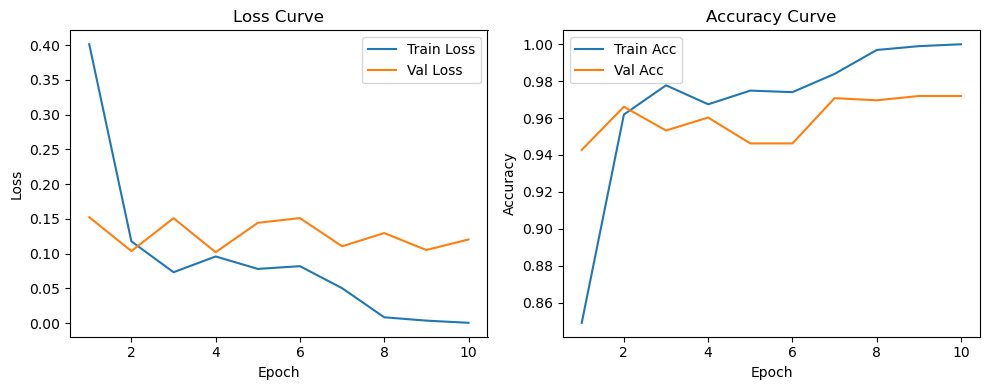

In [11]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()


In [12]:
# Reload best model (safety)
best_model = timm.create_model(model_name, pretrained=False)
best_model.head = nn.Linear(best_model.head.in_features, num_classes)
best_model.load_state_dict(torch.load("best_vit_brain_mri.pth", map_location=device))
best_model = best_model.to(device)

val_loss, val_acc, y_true, y_pred = evaluate(best_model, val_loader, criterion, device)
print("Final Val Loss:", val_loss)
print("Final Val Acc:", val_acc)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


C:\Users\anant\AppData\Local\Temp\ipykernel_23584\3363822965.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_vit_brain_mri.pt

Val:   0%|          | 0/54 [00:08<?, ?it/s]

Final Val Loss: 0.10509383676098794
Final Val Acc: 0.9719626168224299

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.97      0.96       197
  meningioma       0.94      0.95      0.95       193
     notumor       1.00      0.98      0.99       239
   pituitary       0.99      0.98      0.98       227

    accuracy                           0.97       856
   macro avg       0.97      0.97      0.97       856
weighted avg       0.97      0.97      0.97       856

Confusion Matrix:
[[191   5   0   1]
 [  7 184   0   2]
 [  0   4 235   0]
 [  1   3   1 222]]


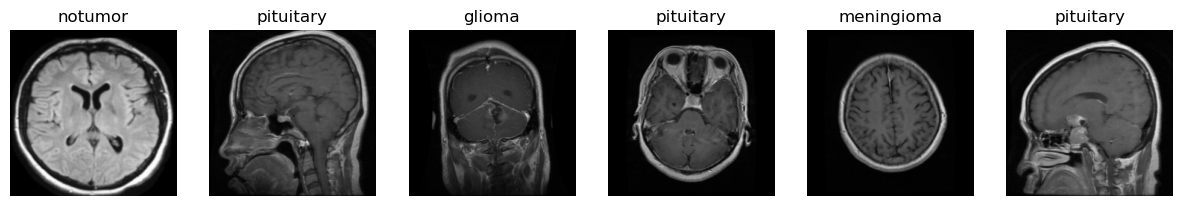

Predictions: ['notumor', 'pituitary', 'glioma', 'pituitary', 'glioma', 'pituitary']
Ground Truth: ['notumor', 'pituitary', 'glioma', 'pituitary', 'meningioma', 'pituitary']


In [14]:
best_model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = best_model(images)
    _, preds = torch.max(outputs, 1)

# Show first 6
show_batch(images.cpu(), labels.cpu(), class_names)

print("Predictions:", [class_names[p.item()] for p in preds[:6]])
print("Ground Truth:", [class_names[l.item()] for l in labels[:6]])


In [17]:
# ================================
#   ONE-CELL GRADIO WEB APP
# ================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import gradio as gr
import numpy as np

# ----- CONFIG -----
IMG_SIZE = 224
num_classes = 4
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# ----- TRANSFORM -----
predict_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----- LOAD MODEL -----
model_name = "vit_base_patch16_224"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = timm.create_model(model_name, pretrained=False)
best_model.head = nn.Linear(best_model.head.in_features, num_classes)

# *** FIXED PATH HERE ***
model_path = r"C:\Users\anant\Downloads\best_vit_brain_mri.pth"

best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

# ----- PREDICT FUNCTION -----
def predict(img):
    img = img.convert("RGB")
    t = predict_transform(img).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = best_model(t)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    prediction = class_names[np.argmax(probs)]
    prob_dict = {class_names[i]: float(probs[i]) for i in range(num_classes)}

    return prediction, prob_dict

# ----- LAUNCH GRADIO -----
gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(label="Predicted Class"),
        gr.Label(label="Class Probabilities")
    ],
    title="Brain MRI Multiclass Tumor Classifier (ViT)",
    description="Upload a brain MRI slice to classify it as glioma, meningioma, pituitary, or no tumor."
).launch(share=True)


C:\Users\anant\AppData\Local\Temp\ipykernel_23584\2853512521.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path, map_locat

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://bb1d4d8e4cdf81246a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
